# Web Scraping Tables in Python

This notebook will go through the process of extracting data from tables on multiple pages on the same website using a combination of `selenium` and `BeautifulSoup`.

The objective is to scrape tables from the football statistics website fbref.com. Specifically, creating a table containing statistics of each team in each season of the Bundesliga in the last 10 years. This information is spread across 10 tables on 10 different pages, so web scraping is used to combine this data into a single `pandas` data frame.

---

### Imports

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup
import requests
from io import StringIO

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

---

### Using `selenium` to get links for each page

There is a page on fbref.com that has links to each Bundesliga season summary page on it. From this page, each link is extracted and added to a list.

Open web page containing Bundesliga seasons glossary:

In [2]:
driver = webdriver.Chrome()

driver.get("https://fbref.com/en/comps/20/history/Bundesliga-Seasons")

Close pop-up asking about cookies:

In [3]:
cookies_button_appears = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "/html/body/div[1]/div/div/div/div[2]/div/button[2]")))

decline_cookies_button = driver.find_element(by=By.XPATH, value="/html/body/div[1]/div/div/div/div[2]/div/button[2]")
decline_cookies_button.click()

Find the table containing links to each season page:

In [4]:
seasons_table = driver.find_element(by=By.XPATH, value="/html/body/div[3]/div[7]/div[2]/div[2]/table/tbody")

Extract links to season pages from table. Also, store the season for later use:

In [5]:
links = []
seasons = []
for row in seasons_table.find_elements(by=By.TAG_NAME, value="tr"):
    season_link = row.find_element(by=By.TAG_NAME, value="th").find_element(by=By.TAG_NAME, value="a").get_attribute("href")
    links.append(season_link)
    season_text = row.find_element(by=By.TAG_NAME, value="th").find_element(by=By.TAG_NAME, value="a").text
    seasons.append(season_text)

driver.quit()

First 5 links and seasons to show this has worked:

In [6]:
links[:5]

['https://fbref.com/en/comps/20/Bundesliga-Stats',
 'https://fbref.com/en/comps/20/2022-2023/2022-2023-Bundesliga-Stats',
 'https://fbref.com/en/comps/20/2021-2022/2021-2022-Bundesliga-Stats',
 'https://fbref.com/en/comps/20/2020-2021/2020-2021-Bundesliga-Stats',
 'https://fbref.com/en/comps/20/2019-2020/2019-2020-Bundesliga-Stats']

In [7]:
seasons[:5]

['2023-2024', '2022-2023', '2021-2022', '2020-2021', '2019-2020']

### Using `BeautifulSoup` to extract the tables from each link

`BeautifulSoup` will take the html code from each web page in the first 10 links (for the last 10 seasons needed for this exercise), and extract only the relevant table using its ID. Then, pandas is used to convert the html to a data frame, which is then added to an overall data frame.

In [8]:
df_raw = pd.DataFrame()

for link in links[:10]:
    response = requests.get(link)
    soup = BeautifulSoup(response.text, "html.parser")

    table_html = soup.select_one('table[id^="stats_squads_standard_for"]')

    table = pd.read_html(StringIO(str(table_html)))[0]

    df_raw = pd.concat([df_raw, table], axis="rows")

The final data frame:

In [9]:
df_raw

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
                Squad               # Pl                Age   
0            Augsburg                 22               25.9   
1       Bayern Munich                 21               27.7   
2              Bochum                 23               30.0   
3        Darmstadt 98                 26               27.3   
4            Dortmund                 21               27.5   
..                ...                ...                ...   
13       Paderborn 07                 24               26.8   
14         Schalke 04                 29               25.2   
15          Stuttgart                 24               24.9   
16      Werder Bremen                 31               25.7   
17          Wolfsburg                 22               26.1   

   Unnamed: 3_level_0 Playing Time                    Performance      ...  \
                 Poss           MP Starts   Min   90s         Gls Ast  ...   
0                44.5            8     88   720   8.0          15   9  ...   
1                63.4            8     88   720   8.0          25  20  ...   
2                43.8            8     88   720   8.0           6   5  ...   
3                46.4            8     88   720   8.0          12   7  ...   
4                59.4            8     88   720   8.0          17  12  ...   
..                ...          ...    ...   ...   ...         ...  ..  ...   
13               43.2           34    374  3060  34.0          30  21  ...   
14               51.1           34    374  3060  34.0          40  29  ...   
15               47.5           34    374  3060  34.0          41  29  ...   
16               43.4           34    374  3060  34.0          49  36  ...   
17               54.9           34    374  3060  34.0          71  50  ...   

   Per 90 Minutes                                                             
              Gls   Ast   G+A  G-PK G+A-PK    xG   xAG xG+xAG  npxG npxG+xAG  
0            1.87  1.13  3.00  1.62   2.75  1.44  0.86   2.30  1.24     2.10  
1            3.12  2.50  5.63  2.75   5.25  2.68  2.10   4.77  2.39     4.49  
2            0.75  0.62  1.37  0.62   1.25  1.15  0.86   2.01  1.05     1.91  
3            1.50  0.87  2.37  1.13   2.00  1.38  0.89   2.27  1.09     1.98  
4            2.12  1.50  3.62  2.00   3.50  2.03  1.52   3.55  1.93     3.45  
..            ...   ...   ...   ...    ...   ...   ...    ...   ...      ...  
13           0.88  0.62  1.50  0.85   1.47   NaN   NaN    NaN   NaN      NaN  
14           1.18  0.85  2.03  1.12   1.97   NaN   NaN    NaN   NaN      NaN  
15           1.21  0.85  2.06  1.18   2.03   NaN   NaN    NaN   NaN      NaN  
16           1.44  1.06  2.50  1.32   2.38   NaN   NaN    NaN   NaN      NaN  
17           2.09  1.47  3.56  2.00   3.47   NaN   NaN    NaN   NaN      NaN  

[180 rows x 32 columns]

---

### Cleaning the data frame

First, the multi index is dropped so that there is only one row of column names. To do so, the stats that are per 90 minutes will have to be renamed.

In [10]:
df = df_raw.copy()

df.columns = pd.MultiIndex.from_tuples(
    [col for col in df.columns if col[0] != "Per 90 Minutes"] + 
    [(col[0], col[1] + "/90") for col in df.columns if col[0] == "Per 90 Minutes"]
)

df = df.droplevel(level=0, axis="columns").reset_index(drop=True)

Add a column for the season of each row using the `seasons` list from web scraping section.

In [11]:
df["Season"] = [seasons[i] for i in df.index // 18]

The final data frame:

In [12]:
df

,Squad,# Pl,Age,Poss,MP,Starts,Min,90s,Gls,Ast,...,Ast/90,G+A/90,G-PK/90,G+A-PK/90,xG/90,xAG/90,xG+xAG/90,npxG/90,npxG+xAG/90,Season
0,Augsburg,22,25.9,44.5,8,88,720,8.0,15,9,...,1.13,3.00,1.62,2.75,1.44,0.86,2.30,1.24,2.10,2023-2024
1,Bayern Munich,21,27.7,63.4,8,88,720,8.0,25,20,...,2.50,5.63,2.75,5.25,2.68,2.10,4.77,2.39,4.49,2023-2024
2,Bochum,23,30.0,43.8,8,88,720,8.0,6,5,...,0.62,1.37,0.62,1.25,1.15,0.86,2.01,1.05,1.91,2023-2024
3,Darmstadt 98,26,27.3,46.4,8,88,720,8.0,12,7,...,0.87,2.37,1.13,2.00,1.38,0.89,2.27,1.09,1.98,2023-2024
4,Dortmund,21,27.5,59.4,8,88,720,8.0,17,12,...,1.50,3.62,2.00,3.50,2.03,1.52,3.55,1.93,3.45,2023-2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Paderborn 07,24,26.8,43.2,34,374,3060,34.0,30,21,...,0.62,1.50,0.85,1.47,NaN,NaN,NaN,NaN,NaN,2014-2015
176,Schalke 04,29,25.2,51.1,34,374,3060,34.0,40,29,...,0.85,2.03,1.12,1.97,NaN,NaN,NaN,NaN,NaN,2014-2015
177,Stuttgart,24,24.9,47.5,34,374,3060,34.0,41,29,...,0.85,2.06,1.18,2.03,NaN,NaN,NaN,NaN,NaN,2014-2015
178,Werder Bremen,31,25.7,43.4,34,374,3060,34.0,49,36,...,1.06,2.50,1.32,2.38,NaN,NaN,NaN,NaN,NaN,2014-2015


### Basic usage

Just to illustrate how this data can be useful, the difference between goals and expected goals (excess goals) is plotted for Union Berlin for each season where xG is available (2017/18 onwards).

In [13]:
df_sub = df[(df.Season.isin(seasons[:seasons.index("2016-2017")]) & (df.Squad == "Union Berlin"))].copy()

df_sub["Excess Goals"] = df_sub.Gls - df_sub.xG

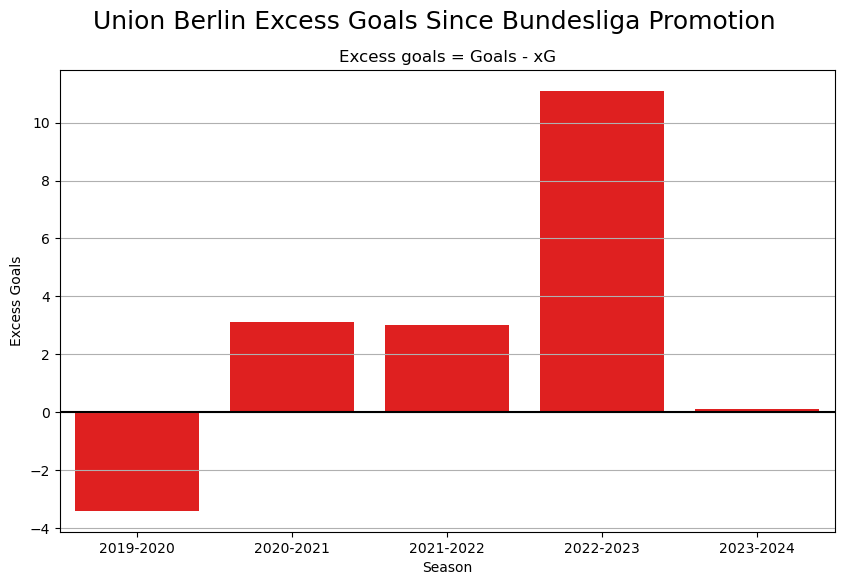

In [15]:
f,a = plt.subplots(figsize=(10,6))

sns.barplot(df_sub.iloc[::-1], y="Excess Goals", x="Season", color="red")
plt.axhline(y=0, color="black")

plt.grid(axis="y")

f.suptitle("Union Berlin Excess Goals Since Bundesliga Promotion", fontsize=18)
a.set_title("Excess goals = Goals - xG", fontsize=12)

plt.show()

- The plot shows that in Union Berlin's first season in the league, they were actually underperforming in terms of their expected scoring performance.
- However, since then they have gone from strength to strength with the 2022/23 season being an amazing overperformance as they qualified for the Champions League for the first time in their history.
- The 2023/24 season, while limited in data, shows that they have had a disappointing goal scoring start to the season compared to previous seasons.